In [1]:
# imports 

import pandas as pd 
import numpy as np
import imageio as im
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import layers

/Users/henryschrader/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


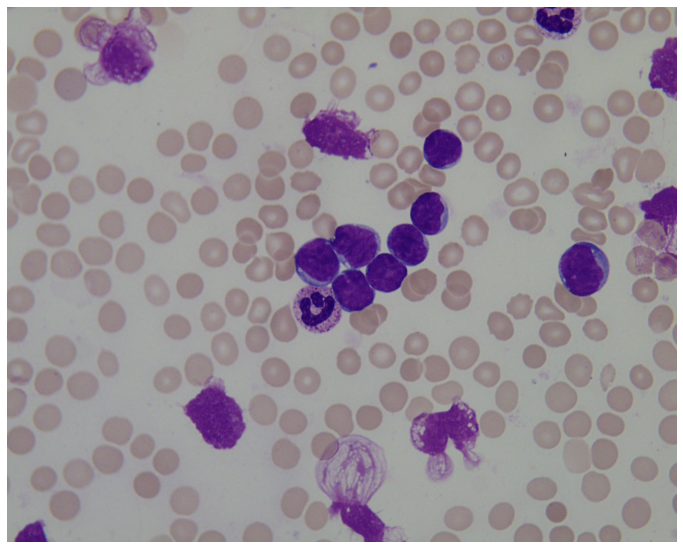

In [2]:
im1 = mpimg.imread("../raw_data/archive/ALL_IDB1/ALL_IDB1/im/im001_1.jpg")

plt.figure(figsize=(12,12))
plt.imshow(im1)
plt.axis("off")
plt.show();

In [3]:
with open("../raw_data/archive/ALL_IDB1/ALL_IDB1/xyc/im001_1.xyc") as tmp:
    test = tmp.read()

In [4]:
test_clear = test.replace("\t"," ").rstrip()
test_clear

'886 726\n796 653\n894 611\n964 681\n1020 605\n1078 529\n1114 361\n1470 671'

In [5]:
test_list = list(test_clear.split("\n"))
test_list

['886 726',
 '796 653',
 '894 611',
 '964 681',
 '1020 605',
 '1078 529',
 '1114 361',
 '1470 671']

In [6]:
test_list[0].split(" ")

['886', '726']

In [7]:
x = []
y = []
for coor in test_list:
    coords = coor.split(" ")
    x.append(int(coords[0]))
    y.append(int(coords[1]))

In [8]:
x

[886, 796, 894, 964, 1020, 1078, 1114, 1470]

In [9]:
y

[726, 653, 611, 681, 605, 529, 361, 671]

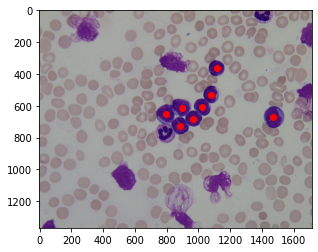

In [10]:
plt.imshow(im1)
plt.scatter(x, y, color="r")
plt.show();

**Proposed Workflow**

1. Preprocessing

2. Blob detection

3. Image segmentation

4. Leukocyte recognition

5. Leukemia classiﬁcation
---

# 1. Preprocessing

HSV-Color Space "explained"

![hsv](https://docs.opencv.org/3.4/Threshold_inRange_HSV_colorspace.jpg)

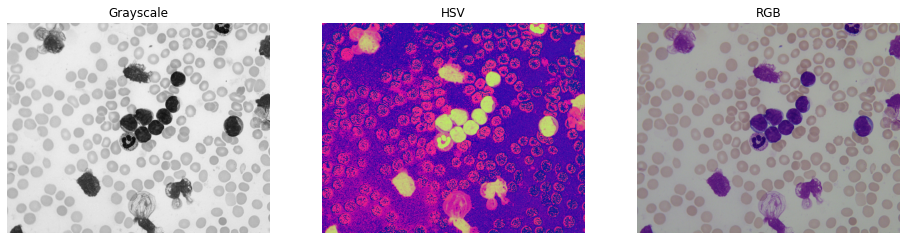

In [11]:
from skimage.color import rgb2hsv
from skimage.color import rgb2gray

im1_gray = rgb2gray(im1)
im1_hsv = rgb2hsv(im1)

plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(im1_gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale")
plt.subplot(1,3,2)
plt.imshow(im1_hsv)
plt.axis("off")
plt.title("HSV")
plt.subplot(1,3,3)
plt.imshow(im1)
plt.axis("off")
plt.title("RGB");

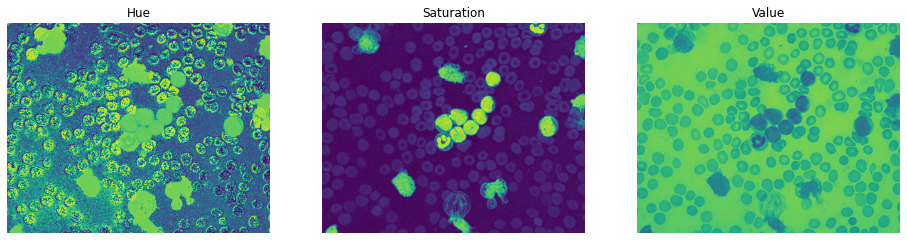

In [12]:
im1_hue = im1_hsv[:,:,0]
im1_sat = im1_hsv[:,:,1]
im1_value = im1_hsv[:,:,2]


plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(im1_hue)
plt.axis("off")
plt.title("Hue")
plt.subplot(1,3,2)
plt.imshow(im1_sat)
plt.axis("off")
plt.title("Saturation")
plt.subplot(1,3,3)
plt.imshow(im1_value)
plt.axis("off")
plt.title("Value");

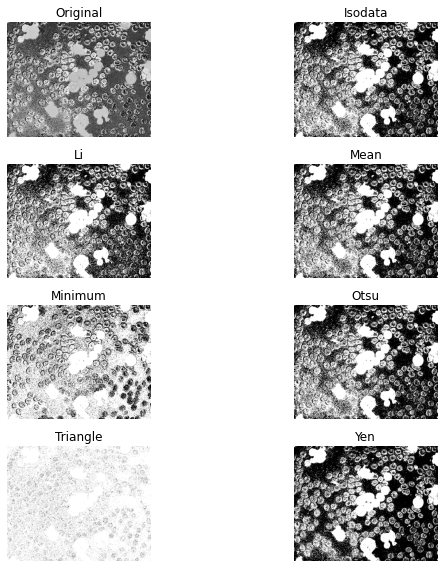

In [13]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(im1_hue, figsize=(10, 8), verbose=False)
plt.show()

**Trying different Thresholds**

___

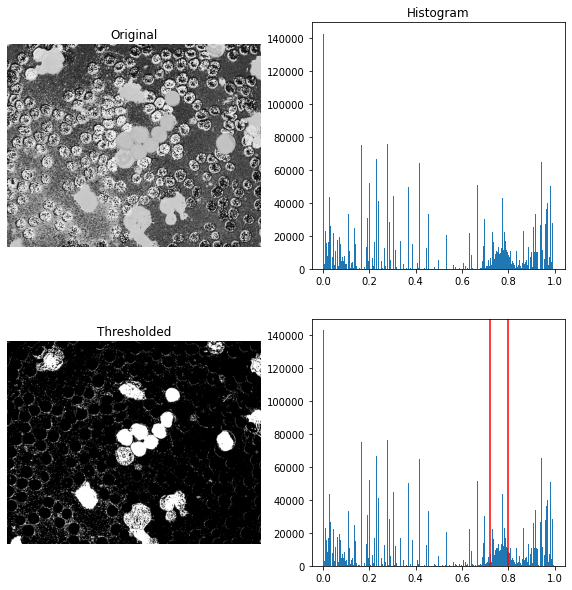

In [14]:
from skimage.filters import threshold_minimum, threshold_otsu, threshold_mean, threshold_isodata, threshold_li, threshold_local
from cv2 import inRange

image = im1_hue

thresh_min = 0.72#threshold_mean(image)
thresh_max = 0.8

binary = inRange(image, thresh_min, thresh_max) #thresh_max > image > thresh

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap="gray")

ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary, cmap="gray")
ax[1, 0].set_title('Thresholded')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')
ax[1, 1].axvline(thresh_max, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

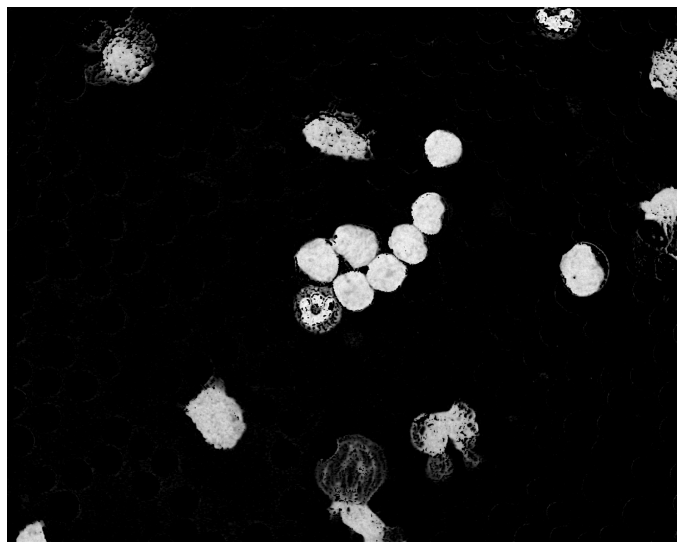

In [15]:
bias = 0.9

im_pre = binary * im1_sat * bias 

plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(im_pre, cmap="gray");

## 1.1 Blob Detection with skimage

---

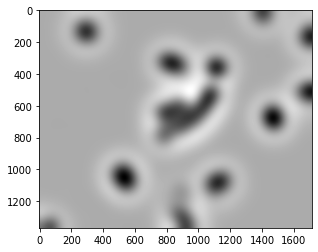

In [16]:
import scipy

im_test = scipy.ndimage.gaussian_laplace(im_pre, 60)
plt.imshow(im_test, cmap="gray");

In [17]:
im_pre.shape

(1368, 1712)

In [18]:
from skimage.feature import blob_log, blob_doh, blob_dog

min_sigma = 42
max_sigma = 45
num_sigma = 2
threshold = 0.995

blobs_log = blob_log(im_pre, max_sigma= max_sigma, min_sigma = min_sigma, num_sigma=num_sigma, threshold=threshold)
#blobs_dog = blob_dog(im_pre_scaled, max_sigma=40, min_sigma=20, threshold=0.1)
#blobs_doh = blob_doh(im_pre_scaled, max_sigma=40, min_sigma=20, num_sigma=20, threshold=0.1)

print(blobs_log.shape)
#print(blobs_dog.shape)
#print(blobs_doh.shape)

(20, 3)


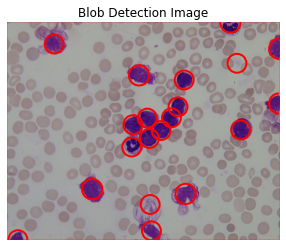

In [32]:
fig, ax = plt.subplots()
ax.imshow(im1, cmap="gray")
for blob in blobs_log:
    y,x,area = blob
    c = plt.Circle((x, y), area * np.sqrt(2), color="r", linewidth=2, fill=False)
    ax.add_patch(c)

ax.set_axis_off()
ax.set_title("Blob Detection Image");

In [21]:
import cv2

img = im1
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv2.dilate(opening,kernel,iterations=3)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1

markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

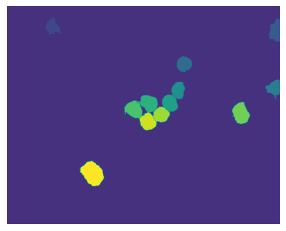

In [22]:
plt.imshow(markers)
plt.axis("off");